In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

from fastai.data_block import DataBunch, DatasetType
from fastai.basics import Learner

import seaborn as sns
sns.set()

%matplotlib inline
%load_ext autoreload
%autoreload 2

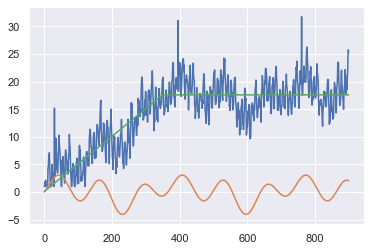

In [7]:
P = 365
P2 = 30.5
N = 900
t = np.arange(N)

# Seasonal
# Coefficients
# Yearly
an = [1, 0.5, -1.5]
bn = [1, -0.5, 1.5]
# Monthly
an2 = [-1, 0.5, -1.5]
bn2 = [1, -0.5, 2]
s = [a*np.cos(2*np.pi*(n+1)*t/P) + b*np.sin(2*np.pi*(n+1)*t/P)
     for n,(a,b) in enumerate(zip(an, bn))]
s2 = [a*np.cos(2*np.pi*(n+1)*t/P2) + b*np.sin(2*np.pi*(n+1)*t/P2)
     for n,(a,b) in enumerate(zip(an2, bn2))]


###########
# Trend
trend = 0.05*t + 0.1
trend[t>350] = -0*(t[t>350] - 350) + trend[t==350]

############
# Holidays
first = 30
val = 15
h = np.zeros_like(trend)
while first < len(trend):
    h[first] = val
    first += 365

y = sum(s) + sum(s2) + trend + h
noise = np.random.randn(*y.shape)
y += noise
y = np.clip(y, 1, 50)

plt.plot(t, y)
plt.plot(t, sum(s))
# plt.plot(t, sum(s2))
plt.plot(t, trend)
plt.show()

In [8]:
class TimeSeries(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x, self.y = x, y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return torch.Tensor([self.x[i]]), torch.Tensor([self.y[i]])

In [9]:
train_len = int(0.8*len(y))
train_ds = TimeSeries(t[:train_len], y[:train_len])
test_ds = TimeSeries(t[train_len:], y[train_len:])
bs = 96
db = DataBunch.create(train_ds, test_ds, bs=bs)

In [98]:
torch.arange(5) // 2

tensor([0, 0, 1, 1, 2])

In [104]:
w = nn.Parameter(torch.zeros(1)+0.5)

In [105]:
w

Parameter containing:
tensor([0.5000], requires_grad=True)

In [107]:
(torch.remainder(torch.arange(5), 2) == 0).float() * w

tensor([0.5000, 0.0000, 0.5000, 0.0000, 0.5000], grad_fn=<MulBackward0>)

In [108]:
class Holiday(nn.Module):
    def __init__(self, holiday, repeat_every=365):
        super().__init__()
        self.holiday = holiday
        self.repeat_every = repeat_every
        self.w = nn.Parameter(torch.zeros(1)+0.05)
        
    def forward(self, t):
        rem = torch.remainder(t - self.holiday, self.repeat_every)
        return (rem == 0).float() * self.w

In [123]:
class HolidayRange(nn.Module):
    def __init__(self, holidays):
        """
        holidays: list of lists containing lower and upper bound of hols
        """
        super().__init__()
        self.holidays = holidays
        self.w = nn.Parameter(torch.zeros(1)+0.05)
        
    def forward(self, t):
        bounded = [(l<=t) & (t<=u) for l,u in self.holidays]
        return sum(bounded).float()*self.w

In [124]:
hol = HolidayRange([[5,10], [30,40]])

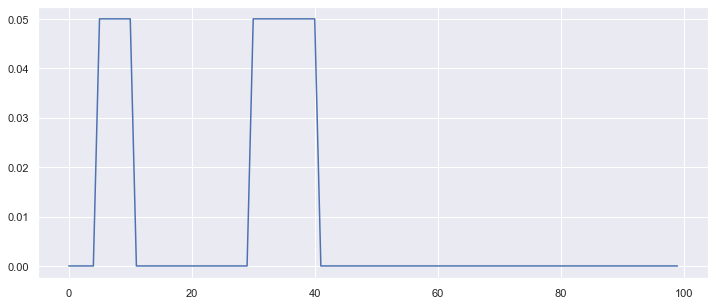

In [125]:
t = torch.arange(100)
y = hol(t)
plt.figure(figsize=(12,5))
plt.plot(t.numpy(), y.detach().numpy())
plt.show()

In [109]:
hol = Holiday(5, 10)

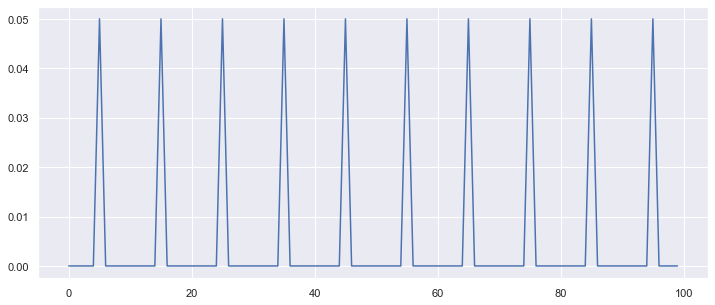

In [112]:
t = torch.arange(100)
y = hol(t)
plt.figure(figsize=(12,5))
plt.plot(t.numpy(), y.detach().numpy())
plt.show()

In [72]:
class FourierModel(nn.Module):
    def __init__(self, p=365.25, n=7, init=None):
        super().__init__()
        self.p, self.n = p, n
        np = [(i+1, p) for i in range(n)]
        self.np = np
        if n > 0:
            self.linear = nn.Linear(n, 1, bias=False)
            # initialise weight parameters
            self.linear.weight.data = init
        
    def forward(self, x):
        if self.n > 0:
            cos = [torch.cos(2*np.pi*n*x/p) for n,p in self.np]
            sin = [torch.sin(2*np.pi*n*x/p) for n,p in self.np]

            return self.linear(torch.cat(cos + sin, dim=1))
        
        else:
            return 0
    
    def plot(self):
        if self.n > 0:
            x = torch.linspace(0, self.p, steps=100)
            y = self.forward(x[:,None])
            plt.figure(figsize=(12,5))
            plt.plot(x.cpu().numpy(), y.detach().cpu().numpy())
            plt.show()

In [73]:
class Seasonal(nn.Module):
    def __init__(self, y_n=7, m_n=5, w_n=0, 
                 y_p=365.25, m_p=30.5, w_p=7):
        super().__init__()
        # Calculate Xavier Glorot initialisation
        fourier_components = 2 * np.array([y_n, m_n, w_n])
        idxs = np.cumsum(fourier_components)
        fan_in = idxs[-1] + 1 # +1 due to trend
        fan_out = 1
        std = np.sqrt(2/(fan_in + fan_out))
        w = torch.randn(1, idxs[-1]) * std
        w = torch.clamp(w, -2*std, 2*std)
        
        self.yearly = FourierModel(y_p, y_n, w[:,:idxs[0]])
        self.monthly = FourierModel(m_p, m_n, w[:,idxs[0]:idxs[1]])
        self.weekly = FourierModel(w_p, w_n, w[:,idxs[1]:idxs[2]])
        
    def forward(self, x):
        return self.yearly(x) + self.monthly(x) + self.weekly(x)

In [74]:
class Squasher(nn.Module):
    def __init__(self, low, high, alpha=0.01):
        super().__init__()
        self.L, self.H, self.alpha = low, high, alpha
    def forward(self, x): 
        x[x < self.L] = self.alpha * (x[x < self.L] - self.L) + self.L
        x[x > self.H] = self.alpha * (x[x > self.H] - self.H) + self.H
        return x

Parameter containing:
tensor([0.], requires_grad=True)

In [75]:
class Trend(nn.Module):
    """
    Broken Trend model, with breakpoints as defined by user.
    """
    def __init__(self, breakpoints):
        super().__init__()
        self.bpoints = breakpoints
        self.init_layer = nn.Linear(1,1) # first linear bit
        self.init_layer.weight.data = torch.Tensor([0.])
        self.init_layer.bias.data = torch.Tensor([0.])
#         import pdb; pdb.set_trace()
            
        if len(breakpoints>0):
            # create deltas which is how the gradient will change
            deltas = torch.zeros(len(breakpoints)) / len(breakpoints) # initialisation
            self.deltas = nn.Parameter(deltas) # make it a parameter
        
    def __copy2array(self):
        """
        Saves parameters into wb
        """
        # extract gradient and bias
        w = self.init_layer.weight
        b = self.init_layer.bias
        self.params = [[w,b]] # save it to buffer
        for d, x1 in zip(self.deltas, self.bpoints):
            y1 = w *x1 + b # find the endpoint of line segment (x1, y1)
            w = w + d # add on the delta to gradient 
            b = y1 - w * x1 # find new bias of line segment 
            self.params.append([w,b]) # add to buffer

        # create buffer
        self.wb = torch.zeros(len(self.params), len(self.params[0]))
        for i in range(self.wb.shape[0]):
            for j in range(self.wb.shape[1]):
                self.wb[i,j] = self.params[i][j]
        
    def forward(self, x):
        self.__copy2array() # copy across parameters into matrix
        
        # get the line segment area (x_sec) for each x
        x_sec = x >= self.bpoints
        x_sec = x_sec.sum(1)
        
        # get final prediction y = mx +b for relevant section
        return x*self.wb[x_sec][:,:1] + self.wb[x_sec][:,1:]

In [76]:
class Model(nn.Module):
    def __init__(self, breakpoints, low, high, y_n=7, m_n=5, w_n=0):
        super().__init__()
        self.trend = Trend(breakpoints)
        self.seasonal = Seasonal(y_n, m_n, w_n)
        self.squash = Squasher(low, high)

    def forward(self, x):
        return self.squash(self.seasonal(x) +self.trend(x))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


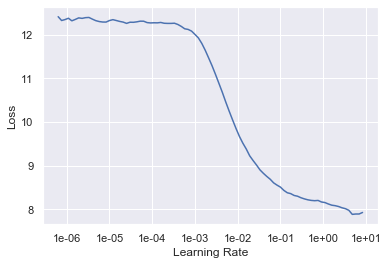

In [84]:
breakpoints = torch.Tensor([250, 500])
model = Model(breakpoints, 1, 20)
learner = Learner(db, model, loss_func=F.l1_loss)
wd = 1e-2
learner.lr_find(wd=wd)
learner.recorder.plot(skip_end=0)

In [85]:
epochs = 20
learner.fit_one_cycle(epochs, 1e-2, wd=wd)

epoch,train_loss,valid_loss,time
0,12.071995,12.390708,00:00
1,10.565497,2.725091,00:00
2,8.328546,2.864912,00:00
3,6.688905,3.012794,00:00
4,5.803477,3.074228,00:00
5,5.203318,3.053208,00:00
6,4.731119,3.004323,00:00
7,4.357019,2.969630,00:00
8,4.065089,2.976595,00:00
9,3.824108,2.965783,00:00


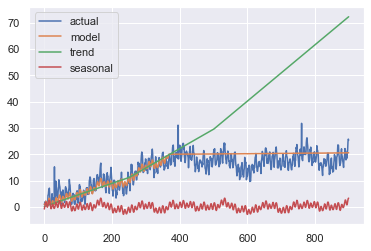

In [86]:
y2 = learner.model(torch.Tensor(t)[:,None])
y3 = learner.model.trend(torch.Tensor(t)[:,None])
y4 = learner.model.seasonal(torch.Tensor(t)[:,None])
plt.plot(t, y, label='actual')
plt.plot(t, y2.detach().cpu().numpy().squeeze(), label='model')
plt.plot(t, y3.detach().cpu().numpy().squeeze(), label='trend')
plt.plot(t, y4.detach().cpu().numpy().squeeze(), label='seasonal')
plt.legend()
plt.show()

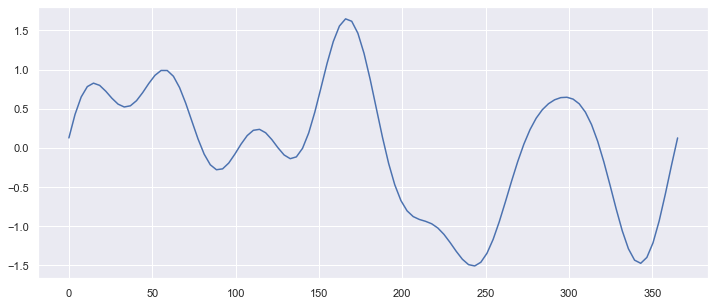

In [87]:
learner.model.seasonal.yearly.plot()

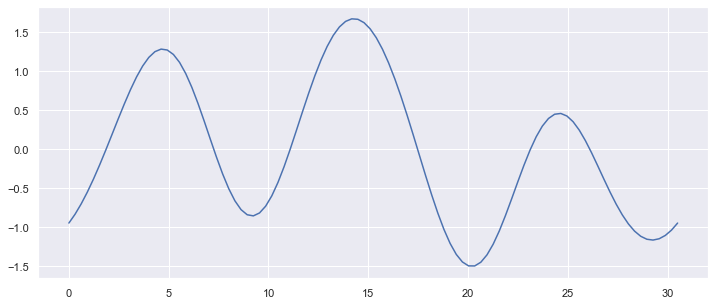

In [88]:
learner.model.seasonal.monthly.plot()